<center><a target="_blank" href="https://academy.constructor.org/"><img src=https://lh3.googleusercontent.com/d/1EmH3Jks5CpJy0zK3JbkvJZkeqWtVcxhB width="500" style="background:none; border:none; box-shadow:none;" /></a> </center>
<hr />

# <h1 align="center"> Model Interpretation: SHAP </h1>

<hr />
<center>Constructor Academy, 2024</center>


# Load Dependencies

In [1]:
%pip install shap

  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 16.6 MB/s eta 0:00:00
Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 70.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 64.3 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Data generation

In [5]:
orig_url = "https://drive.google.com/file/d/15H8TTe7mZQV4QYiV545k7_WjNcO5_lT-/view"
file_id = orig_url.split('/')[-2]
data_path='https://drive.google.com/uc?export=download&id=' + file_id

In [6]:
pd.set_option('display.max_columns', None)
data = pd.read_csv(data_path, delimiter=",")
print(data.shape)
data.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [9]:
data = data.drop(["id", "Unnamed: 32"], axis=1, errors='ignore')
# data.rename(columns={'concave points_mean':'concave_points_mean', 'concave points_se':'concave_points_se', 'concave points_worst':'concave_points_worst'}, inplace=True)
data["diagnosis"] = data["diagnosis"].replace(["B", "M"], [0, 1])

y = data['diagnosis']
X = data.drop("diagnosis", axis=1, errors='ignore')
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=data["diagnosis"], random_state=50
)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 398 samples.
Testing set has 171 samples.


In [12]:
X_train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
479,16.250,19.51,109.80,815.8,0.10260,0.18930,0.22360,0.09194,0.2151,0.06578,0.3147,0.9857,3.070,33.12,0.009197,0.054700,0.080790,0.022150,0.02773,0.006355,17.39,23.05,122.10,939.7,0.1377,0.44620,0.58970,0.17750,0.3318,0.09136
98,11.600,12.84,74.34,412.6,0.08983,0.07525,0.04196,0.03350,0.1620,0.06582,0.2315,0.5391,1.475,15.75,0.006153,0.013300,0.016930,0.006884,0.01651,0.002551,13.06,17.16,82.96,512.5,0.1431,0.18510,0.19220,0.08449,0.2772,0.08756
281,11.740,14.02,74.24,427.3,0.07813,0.04340,0.02245,0.02763,0.2101,0.06113,0.5619,1.2680,3.717,37.83,0.008034,0.014420,0.015140,0.018460,0.02921,0.002005,13.31,18.26,84.70,533.7,0.1036,0.08500,0.06735,0.08290,0.3101,0.06688
81,13.340,15.86,86.49,520.0,0.10780,0.15350,0.11690,0.06987,0.1942,0.06902,0.2860,1.0160,1.535,12.96,0.006794,0.035750,0.039800,0.013830,0.02134,0.004603,15.53,23.19,96.66,614.9,0.1536,0.47910,0.48580,0.17080,0.3527,0.10160
566,16.600,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.037310,0.047300,0.015570,0.01318,0.003892,18.98,34.12,126.70,1124.0,0.1139,0.30940,0.34030,0.14180,0.2218,0.07820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,9.567,15.91,60.21,279.6,0.08464,0.04087,0.01652,0.01667,0.1551,0.06403,0.2152,0.8301,1.215,12.64,0.011640,0.010400,0.011860,0.009623,0.02383,0.003540,10.51,19.16,65.74,335.9,0.1504,0.09515,0.07161,0.07222,0.2757,0.08178
125,13.850,17.21,88.44,588.7,0.08785,0.06136,0.01420,0.01141,0.1614,0.05890,0.2185,0.8561,1.495,17.91,0.004599,0.009169,0.009127,0.004814,0.01247,0.001708,15.49,23.58,100.30,725.9,0.1157,0.13500,0.08115,0.05104,0.2364,0.07182
79,12.860,18.00,83.19,506.3,0.09934,0.09546,0.03889,0.02315,0.1718,0.05997,0.2655,1.0950,1.778,20.35,0.005293,0.016610,0.020710,0.008179,0.01748,0.002848,14.24,24.82,91.88,622.1,0.1289,0.21410,0.17310,0.07926,0.2779,0.07918
560,14.050,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.4920,2.888,29.84,0.007256,0.026780,0.020710,0.016260,0.02080,0.005304,15.30,33.17,100.20,706.7,0.1241,0.22640,0.13260,0.10480,0.2250,0.08321


# Interpreting Classification Models

We will look at how to interpret a variety of classification models here:

- Logistic Regression
- XGBoost Classifier

## Interpreting Logistic Regression Model


### Train and Evaluate Model Performance

In [13]:
from sklearn.linear_model import LogisticRegression

lor = LogisticRegression(solver='liblinear')

lor.fit(X_train.values, y_train)

pred_lor = lor.predict(X_test.values)

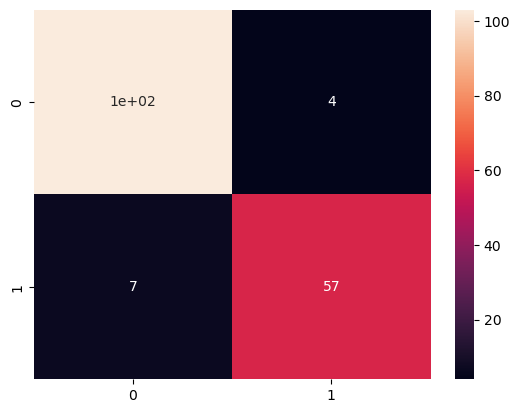

In [14]:
cf = confusion_matrix(y_test, pred_lor)
sns.heatmap(cf, annot=True);

In [15]:
print(classification_report(y_test, pred_lor))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       107
           1       0.93      0.89      0.91        64

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



### Create SHAP Explainer & Compute SHAP values

In [16]:
explainer = shap.KernelExplainer(lor.predict, data=X_train)
shap_values = explainer.shap_values(X_test)

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 171/171 [05:47<00:00,  2.03s/it]


### View SHAP values

In [17]:
X_test.head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
292,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,0.06470,0.2094,0.7636,1.2310,17.670,0.008725,0.02003,0.02335,0.01132,0.02625,0.004726,13.74,19.93,88.81,585.4,0.14830,0.2068,0.2241,0.10560,0.3380,0.09584
547,10.26,16.58,65.85,320.8,0.08877,0.08066,0.04358,0.02438,0.1669,0.06714,0.1144,1.0230,0.9887,7.326,0.010270,0.03084,0.02613,0.01097,0.02277,0.005890,10.83,22.04,71.08,357.4,0.14610,0.2246,0.1783,0.08333,0.2691,0.09479
402,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,0.2357,1.2990,2.3970,20.210,0.003629,0.03713,0.03452,0.01065,0.02632,0.003705,14.13,24.61,96.31,621.9,0.09329,0.2318,0.1604,0.06608,0.3207,0.07247


In [18]:
pd.DataFrame(shap_values, columns=X_test.columns).head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.038657,0.029081,0.037421,-0.064611,0.002352,-0.003223,0.002312,0.000000,0.000000,0.002324,0.001266,0.008835,0.017949,-0.091410,0.000000,0.000000,-0.002974,-0.003996,0.002693,-0.004882,0.068060,-0.067100,-0.195826,-0.142562,0.003310,0.001119,-0.005630,0.000000,0.000000,0.000000
1,0.144918,0.018650,0.124028,-0.132695,0.004776,0.004121,-0.002358,-0.002386,0.002718,0.000000,-0.002198,0.003173,0.008861,-0.107629,-0.003711,0.004859,0.000000,0.003604,0.004170,-0.008778,0.149664,-0.038794,-0.305525,-0.223269,0.008074,-0.007720,-0.001964,-0.002277,-0.006592,-0.002553
2,0.022091,0.014221,0.020835,-0.073514,0.000000,-0.006938,0.000000,-0.005372,0.000000,0.007565,0.004349,-0.009332,0.006464,-0.087339,0.002065,-0.008063,0.000515,0.005489,0.008049,-0.001271,0.058794,-0.046193,-0.115340,-0.148123,-0.003044,-0.005613,0.000000,-0.004821,0.000000,-0.002308


### Global Interpretation - Feature Importance Globally

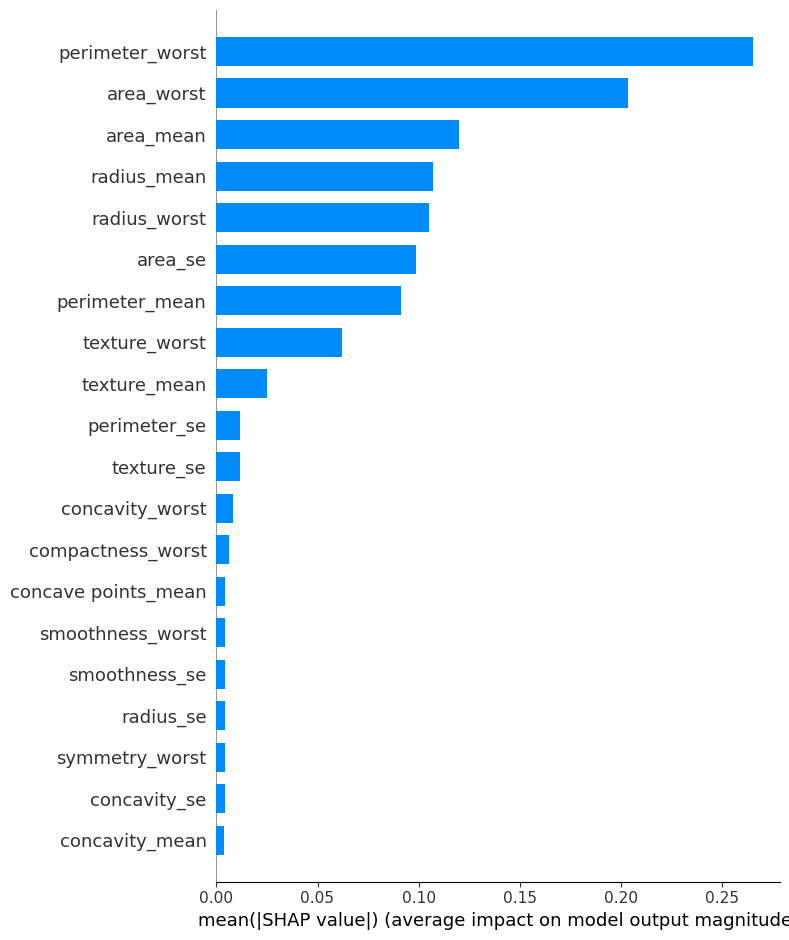

In [19]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

### Local Interpretations

In [20]:
explainer.expected_value

0.3668341708542714

In [21]:
y_test.iloc[10], pred_lor[10]

(1, 1)

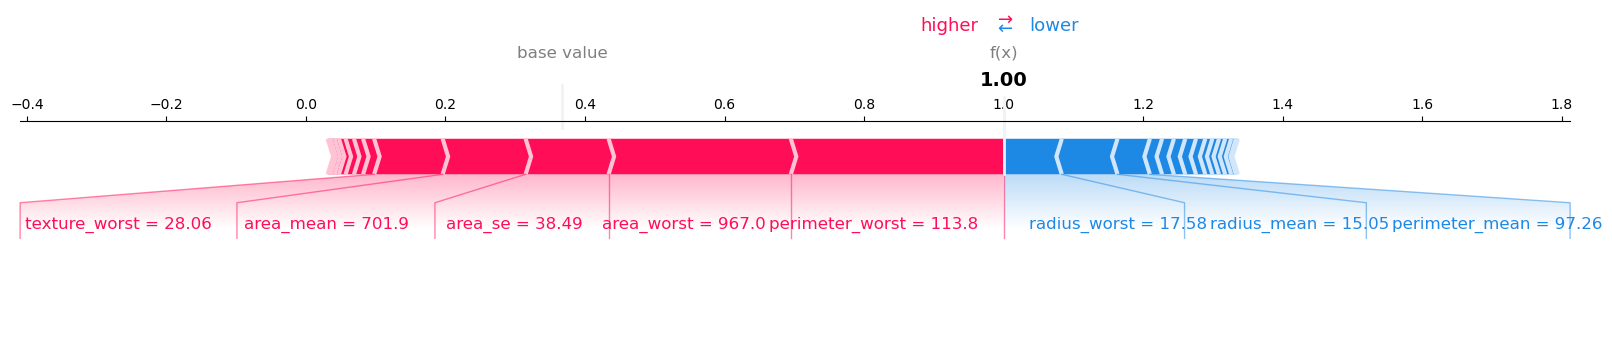

In [22]:
shap.force_plot(explainer.expected_value, shap_values[10, :], X_test.iloc[10, :], matplotlib=True)

In [23]:
y_test.iloc[1], pred_lor[1]

(0, 0)

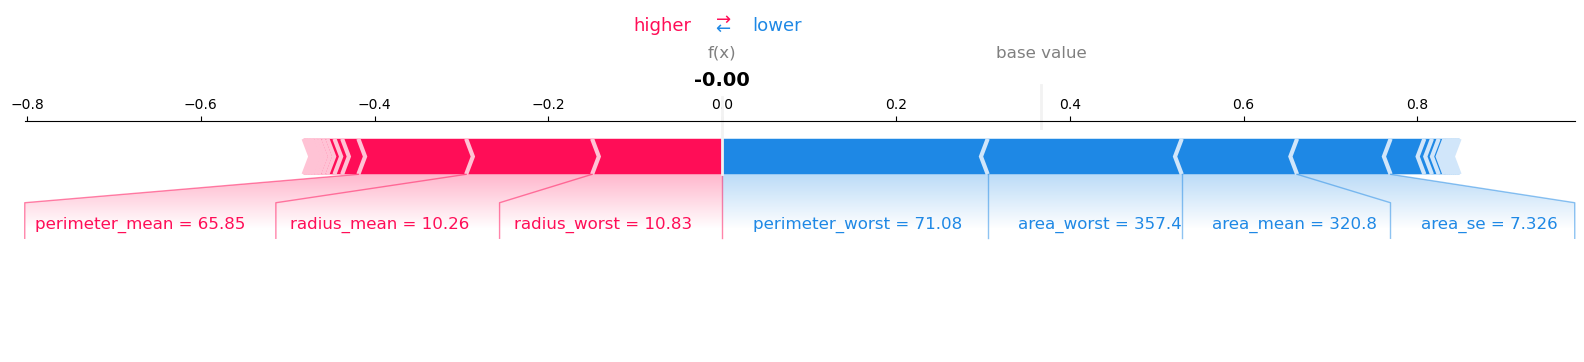

In [24]:
shap.force_plot(explainer.expected_value, shap_values[1, :], X_test.iloc[1, :], matplotlib=True)

### Partial Dependence Plots

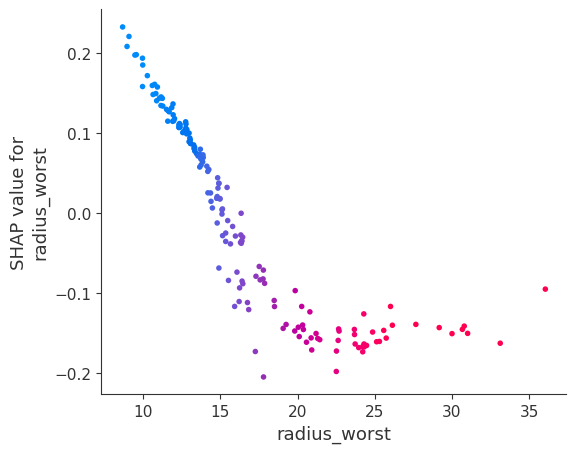

In [25]:
shap.dependence_plot(ind='radius_worst', interaction_index='radius_worst',
                     shap_values=shap_values,
                     features=X_test,
                     display_features=X_test)

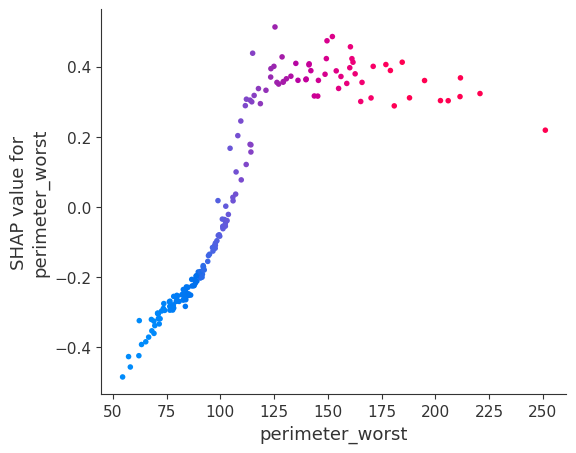

In [26]:
shap.dependence_plot(ind='perimeter_worst', interaction_index='perimeter_worst',
                     shap_values=shap_values,
                     features=X_test,
                     display_features=X_test)

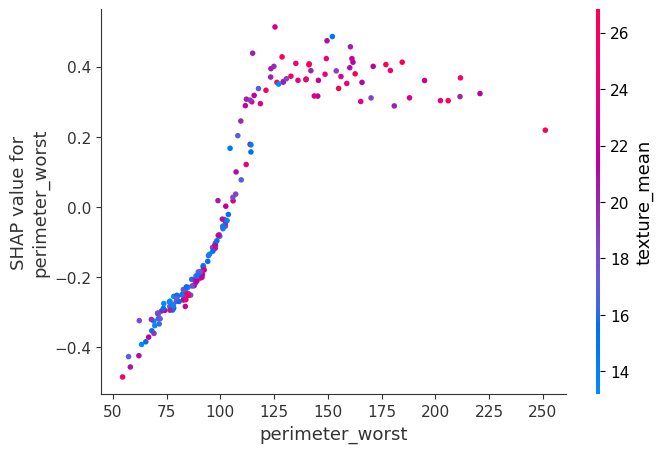

In [27]:
shap.dependence_plot(ind='perimeter_worst', interaction_index='texture_mean',
                     shap_values=shap_values,
                     features=X_test,
                     display_features=X_test)

## Interpreting XGBoost Classifier Model


### Train and Evaluate Model Performance

In [28]:
from xgboost import XGBClassifier


xgb = XGBClassifier()
xgb.fit(X_train, y_train)

pred_xgb = xgb.predict(X_test)

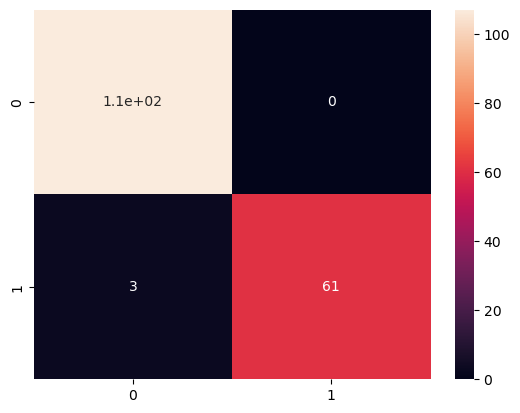

In [29]:
cf = confusion_matrix(y_test, pred_xgb)
sns.heatmap(cf, annot=True);

In [30]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       107
           1       1.00      0.95      0.98        64

    accuracy                           0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



### Create SHAP Explainer & Compute SHAP values

In [31]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

### View SHAP values

In [32]:
X_test.head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
292,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,0.1730,0.06470,0.2094,0.7636,1.2310,17.670,0.008725,0.02003,0.02335,0.01132,0.02625,0.004726,13.74,19.93,88.81,585.4,0.14830,0.2068,0.2241,0.10560,0.3380,0.09584
547,10.26,16.58,65.85,320.8,0.08877,0.08066,0.04358,0.02438,0.1669,0.06714,0.1144,1.0230,0.9887,7.326,0.010270,0.03084,0.02613,0.01097,0.02277,0.005890,10.83,22.04,71.08,357.4,0.14610,0.2246,0.1783,0.08333,0.2691,0.09479
402,12.96,18.29,84.18,525.2,0.07351,0.07899,0.04057,0.01883,0.1874,0.05899,0.2357,1.2990,2.3970,20.210,0.003629,0.03713,0.03452,0.01065,0.02632,0.003705,14.13,24.61,96.31,621.9,0.09329,0.2318,0.1604,0.06608,0.3207,0.07247


In [33]:
pd.DataFrame(shap_values, columns=X_test.columns).head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.013803,-0.061605,0.013028,-0.048970,0.145555,-0.047074,-0.128628,-1.052590,0.019606,0.0,-0.057397,0.0,-0.008228,-0.937353,0.0,-0.156174,0.101986,-0.323778,-0.192921,-0.082723,-0.113882,-1.343763,-0.920643,-1.492760,0.425693,-0.077281,-0.409405,-0.870450,0.283759,-0.09167
1,-0.013803,-0.062641,0.013028,-0.057530,-0.235604,-0.047074,-0.128628,-1.160805,0.065979,0.0,-0.057397,0.0,-0.008228,-0.854317,0.0,-0.263535,0.101986,-0.323778,-0.213205,-0.082723,-0.110624,-1.010213,-0.873210,-1.632519,0.425693,-0.077281,-0.498703,-0.872853,-0.019583,-0.09167
2,-0.041366,-0.074821,0.004302,-0.068245,-0.326048,-0.047074,-0.146875,-1.318418,-0.114859,0.0,-0.057397,0.0,-0.008228,-0.926246,0.0,-0.325201,-0.093881,-0.378483,-0.192921,-0.082723,-0.140470,-0.140642,-0.842142,-1.390000,-0.349161,-0.075336,-0.522030,-0.903467,0.290592,-0.09167


### Global Interpretation - Feature Importance Globally

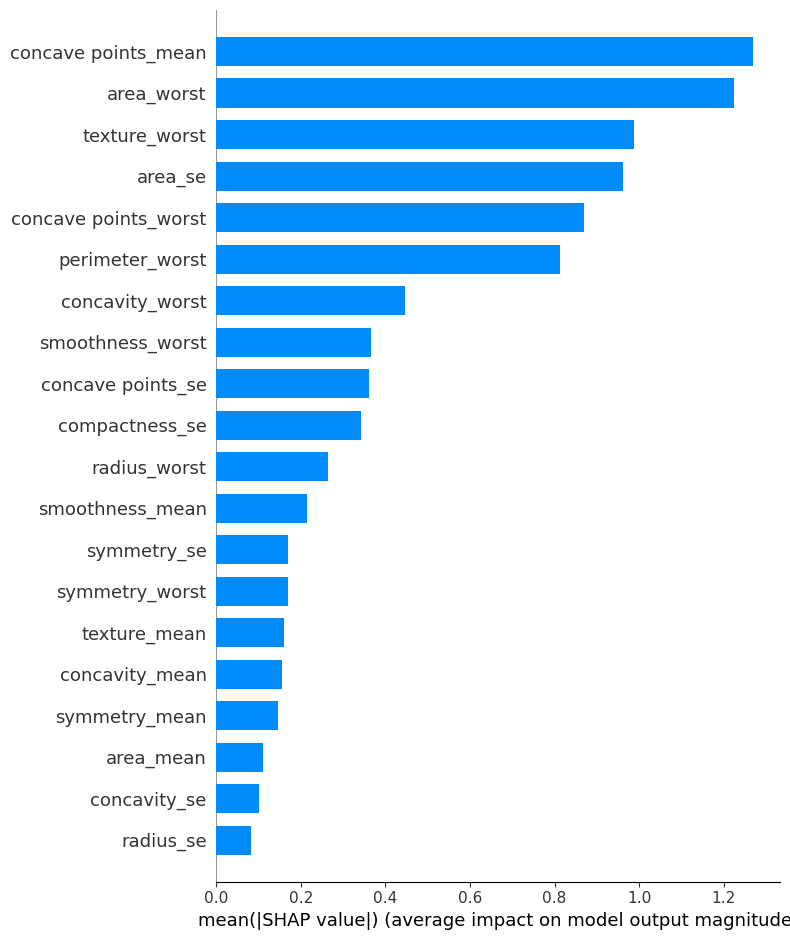

In [34]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

### Local Interpretations

In [35]:
explainer.expected_value

-0.6325137

In [36]:
y_test.iloc[10], pred_xgb[10]

(1, 1)

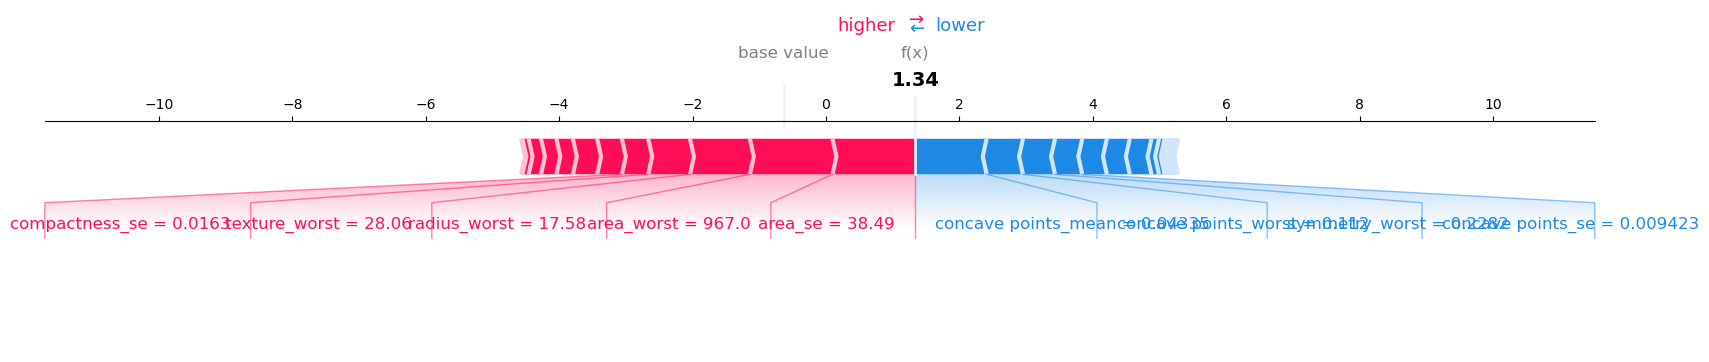

In [37]:
shap.force_plot(explainer.expected_value, shap_values[10, :], X_test.iloc[10, :], matplotlib=True)

In [38]:
y_test.iloc[1], pred_xgb[1]

(0, 0)

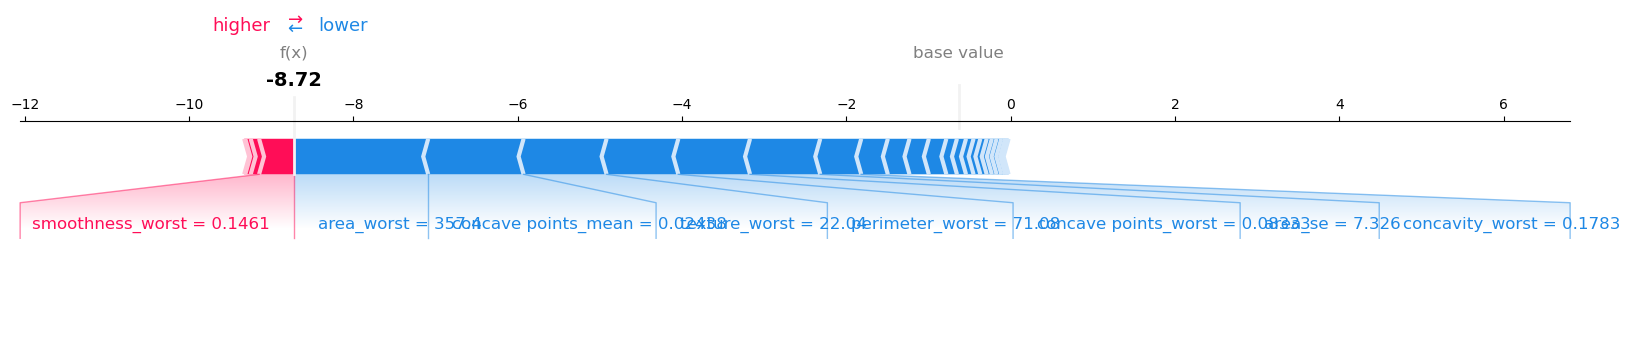

In [39]:
shap.force_plot(explainer.expected_value, shap_values[1, :], X_test.iloc[1, :], matplotlib=True)

### Partial Dependence Plots

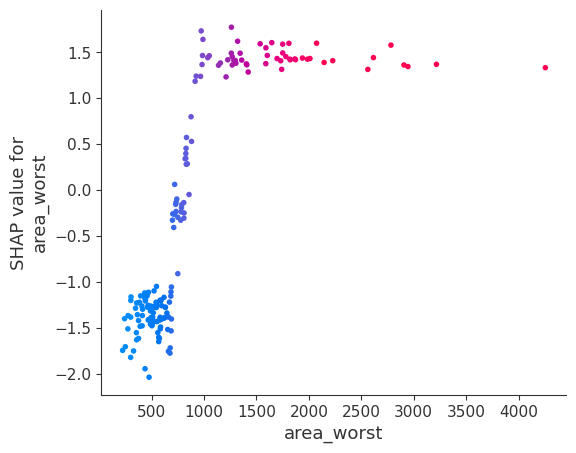

In [40]:
shap.dependence_plot(ind='area_worst', interaction_index='area_worst',
                     shap_values=shap_values,
                     features=X_test,
                     display_features=X_test)

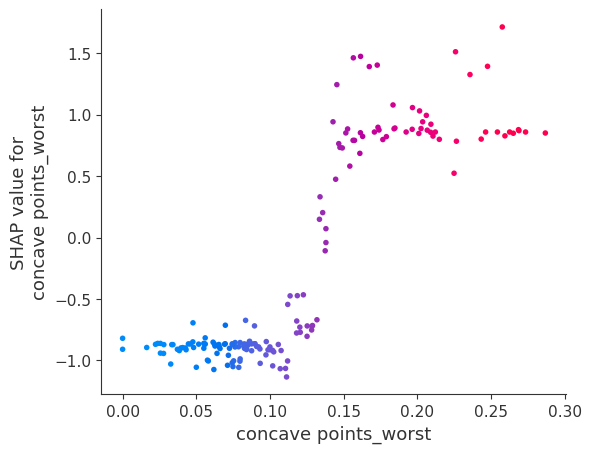

In [41]:
shap.dependence_plot(ind='concave points_worst', interaction_index='concave points_worst',
                     shap_values=shap_values,
                     features=X_test,
                     display_features=X_test)

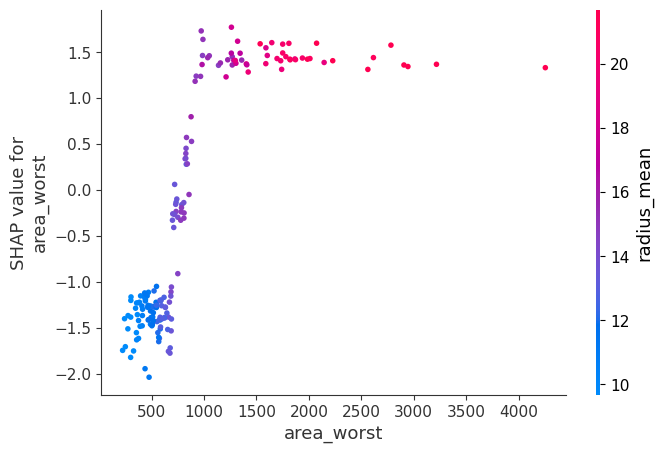

In [42]:
shap.dependence_plot(ind='area_worst', interaction_index='radius_mean',
                     shap_values=shap_values,
                     features=X_test,
                     display_features=X_test)

# Bonus

Compare the results of a baseline model to a model trained using chosen features after feature selection from the exercise on Advanced classification models day.

In [43]:
drop_list1 = [
    "perimeter_mean",
    "area_mean",
    "area_se",
    "perimeter_se",
    "area_worst",
    "perimeter_worst",
    "radius_mean",
    "texture_mean",
    "compactness_mean",
    "concavity_mean",
    "compactness_worst",
    "concavity_worst",
    "concave points_mean",
]

X_train_reduced = X_train.drop(drop_list1, axis=1)
X_test_reduced = X_test.drop(drop_list1, axis=1)


X_train_reduced.head()

,smoothness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
479,0.10260,0.2151,0.06578,0.3147,0.9857,0.009197,0.05470,0.08079,0.022150,0.02773,0.006355,17.39,23.05,0.1377,0.17750,0.3318,0.09136
98,0.08983,0.1620,0.06582,0.2315,0.5391,0.006153,0.01330,0.01693,0.006884,0.01651,0.002551,13.06,17.16,0.1431,0.08449,0.2772,0.08756
281,0.07813,0.2101,0.06113,0.5619,1.2680,0.008034,0.01442,0.01514,0.018460,0.02921,0.002005,13.31,18.26,0.1036,0.08290,0.3101,0.06688
81,0.10780,0.1942,0.06902,0.2860,1.0160,0.006794,0.03575,0.03980,0.013830,0.02134,0.004603,15.53,23.19,0.1536,0.17080,0.3527,0.10160
566,0.08455,0.1590,0.05648,0.4564,1.0750,0.005903,0.03731,0.04730,0.015570,0.01318,0.003892,18.98,34.12,0.1139,0.14180,0.2218,0.07820


In [44]:
from sklearn.linear_model import LogisticRegression

lor = LogisticRegression(solver='liblinear')

lor.fit(X_train_reduced, y_train)

pred_lor = lor.predict(X_test_reduced)

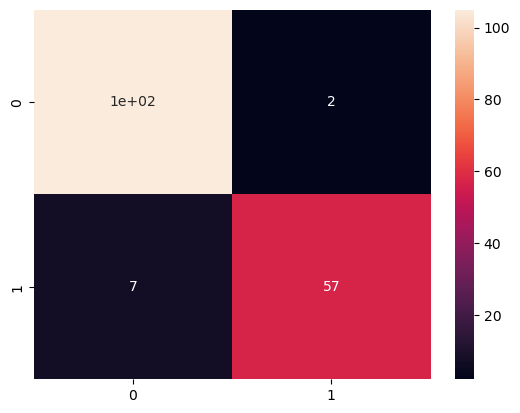

In [45]:
cf = confusion_matrix(y_test, pred_lor)
sns.heatmap(cf, annot=True);

In [46]:
print(classification_report(y_test, pred_lor))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       107
           1       0.97      0.89      0.93        64

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



### Create SHAP Explainer & Compute SHAP values

In [47]:
explainer = shap.KernelExplainer(lor.predict, data=X_train_reduced)
shap_values = explainer.shap_values(X_test_reduced)

Using 398 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 171/171 [05:07<00:00,  1.80s/it]


In [48]:
X_test_reduced.head(3)

,smoothness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
292,0.10050,0.1730,0.06470,0.2094,0.7636,0.008725,0.02003,0.02335,0.01132,0.02625,0.004726,13.74,19.93,0.14830,0.10560,0.3380,0.09584
547,0.08877,0.1669,0.06714,0.1144,1.0230,0.010270,0.03084,0.02613,0.01097,0.02277,0.005890,10.83,22.04,0.14610,0.08333,0.2691,0.09479
402,0.07351,0.1874,0.05899,0.2357,1.2990,0.003629,0.03713,0.03452,0.01065,0.02632,0.003705,14.13,24.61,0.09329,0.06608,0.3207,0.07247


In [49]:
pd.DataFrame(shap_values, columns=X_test_reduced.columns).head(3)

,smoothness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.000000,0.00000,0.0,-0.073436,0.039063,-0.000777,0.001341,-0.001582,0.000884,-0.000735,0.0,-0.220466,-0.051227,0.000000,-0.008614,0.000000,-0.001033
1,-0.000350,0.00000,0.0,-0.055409,0.013022,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.235706,-0.027241,0.000000,-0.009664,-0.001235,0.000000
2,0.001627,0.00058,0.0,-0.067263,-0.006753,-0.000809,0.000000,0.000000,0.000000,0.000000,0.0,-0.211713,-0.014273,-0.000993,-0.015940,-0.000633,-0.000414


### Global Interpretation - Feature Importance Globally

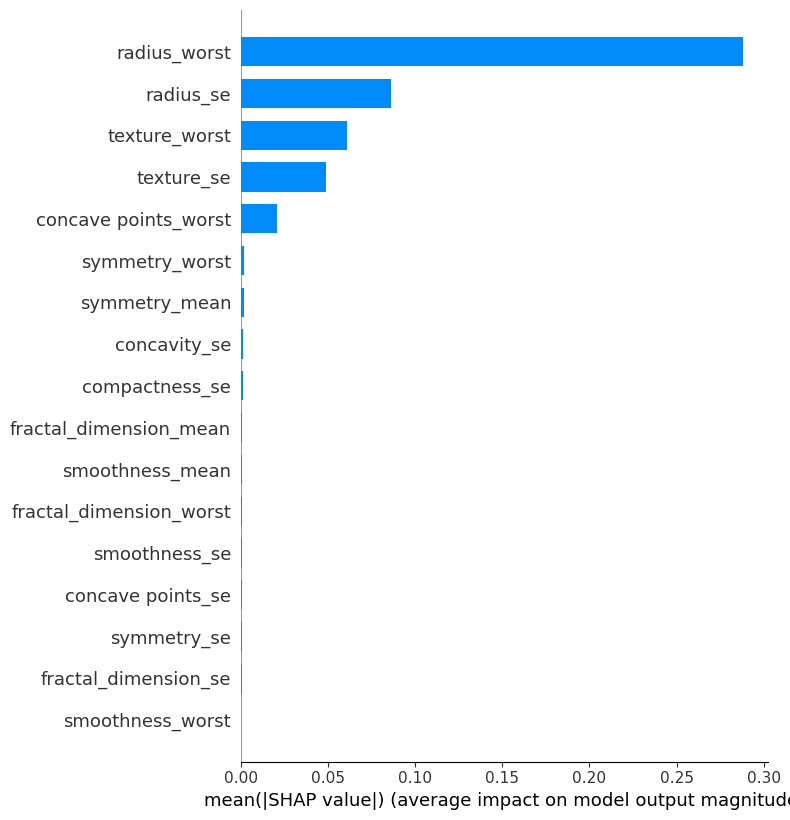

In [50]:
shap.summary_plot(shap_values, X_test_reduced, plot_type='bar')

### Local Interpretations

In [51]:
explainer.expected_value

0.31658291457286436

In [52]:
y_test.iloc[10], pred_lor[10]

(1, 1)

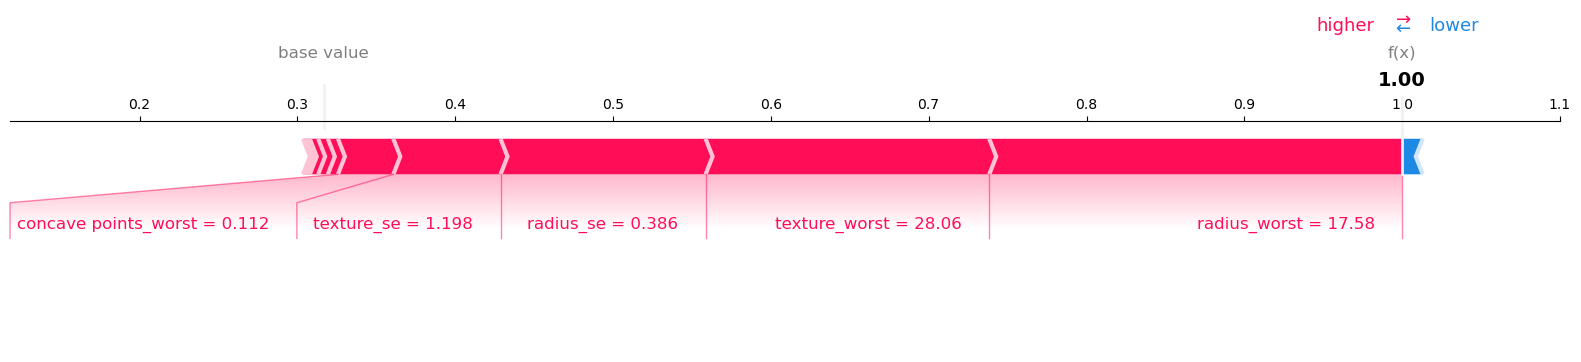

In [53]:
shap.force_plot(explainer.expected_value, shap_values[10, :], X_test_reduced.iloc[10, :], matplotlib=True)

In [54]:
y_test.iloc[1], pred_lor[1]

(0, 0)

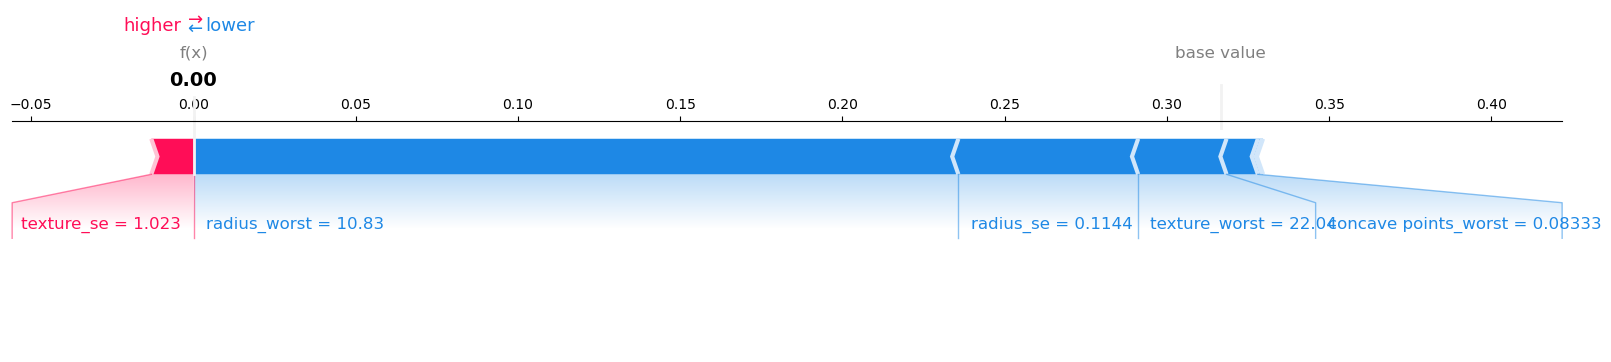

In [55]:
shap.force_plot(explainer.expected_value, shap_values[1, :], X_test_reduced.iloc[1, :], matplotlib=True)

### Partial Dependence Plots

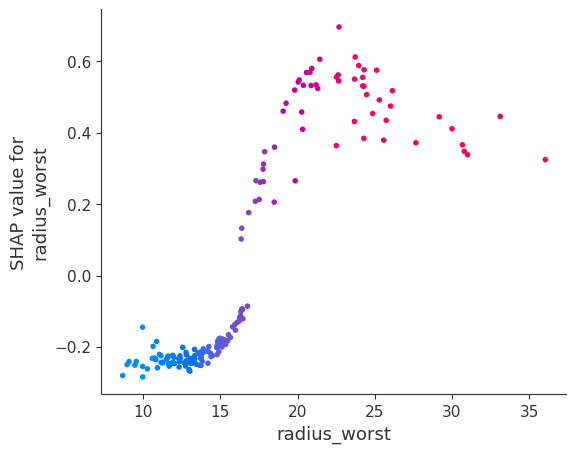

In [56]:
shap.dependence_plot(ind='radius_worst', interaction_index='radius_worst',
                     shap_values=shap_values,
                     features=X_test_reduced,
                     display_features=X_test_reduced)

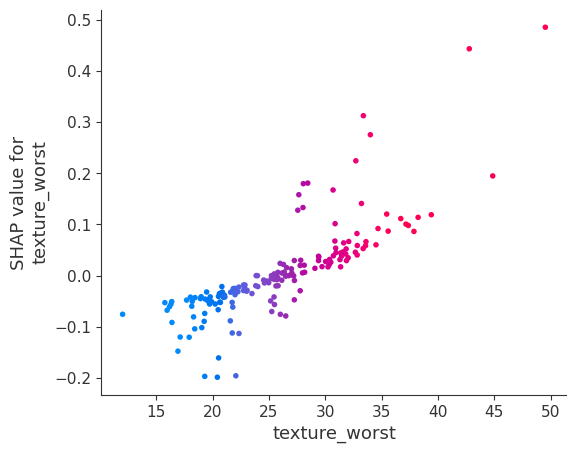

In [57]:
shap.dependence_plot(ind='texture_worst', interaction_index='texture_worst',
                     shap_values=shap_values,
                     features=X_test_reduced,
                     display_features=X_test_reduced)

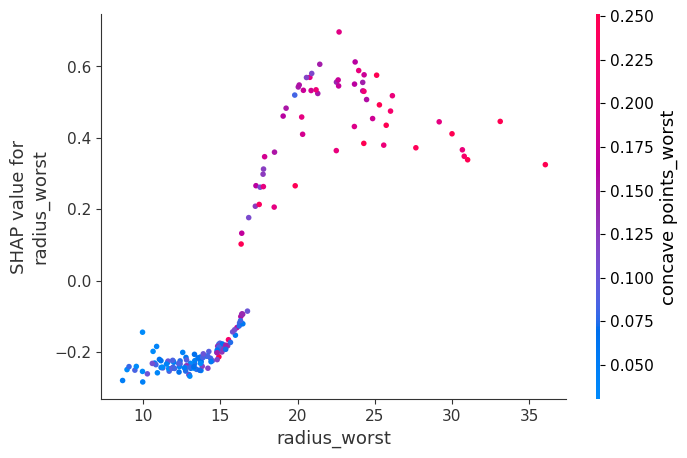

In [58]:
shap.dependence_plot(ind='radius_worst', interaction_index='concave points_worst',
                     shap_values=shap_values,
                     features=X_test_reduced,
                     display_features=X_test_reduced)